<a href="https://colab.research.google.com/github/samarth-shrivastava/Aircraft-Classification/blob/main/classification_of_military_aircrafts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<!-- <p style="background-color:#1D2216;font-family:sans-serif;color:#FFFFFF;font-size:222%;text-align:center;border-radius:10px 10px;">Military aircraft detection and classification </p> -->
<p style="background-color:#1D2216;font-family:sans-serif;color:#FFFFFF;font-size:222%;text-align:center;border-radius:10px 10px;">Global AeroTech Classifier :  </p>
<div  style="background-color:#1D2216;font-family:sans-serif;color:#FFFFFF;font-size:100%;text-align:center;border-radius:10px 10px;">A comprehensive System for Aircraft and other Aviation Object identification
</div>




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#____________________________________________________________

import glob
import pathlib
import tensorflow as tf
import cv2, os, random
from termcolor import colored
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)

#____________________________________________________________

directory = "E:/airplanes_data/archive/crop/"
path_for_data = pathlib.Path(directory)

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...


#### <span style='background:#1D2216;color:#ffffff;'> Load the dataset from directory </span>

In [ ]:
train_df = image_dataset_from_directory(path_for_data,
                                        image_size = (128, 128),
                                        validation_split = 0.3,
                                        subset = "training",
                                        shuffle = True,
                                        batch_size = 25,
                                        seed = 123)

validation_df = image_dataset_from_directory(path_for_data,
                                             image_size = (128, 128),
                                             validation_split = 0.35,
                                             subset = "validation",
                                             shuffle = True,
                                             batch_size = 25,
                                             seed = 123)

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

Found 37497 files belonging to 74 classes.
Using 26248 files for training.
Found 37497 files belonging to 74 classes.
Using 13123 files for validation.
The datasets were succesfully loaded...


#### <span style='background:#1D2216;color:#ffffff;'> Look at train and test sets </span>

In [ ]:
train_df, validation_df

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

#### <span style='background:#1D2216;color:#ffffff;'> The number of images in each dataset </span>

In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 1050 images in the training dataset
There is 525 images in the validation dataset


#### <span style='background:#1D2216;color:#ffffff;'> Create validation and test sets from 'validation_df' </span>

In [ ]:
validation_batches = tf.data.experimental.cardinality(validation_df)
validation_batches

<tf.Tensor: shape=(), dtype=int64, numpy=525>

In [ ]:
# take validation batches for test set
test_df = validation_df.take(validation_batches // 5)

# skip validation batches for validation set
validation_df = validation_df.skip(validation_batches // 5)

test_df, validation_df

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

#### <span style='background:#1D2216;color:#ffffff;'> Let's look at some of the images </span>

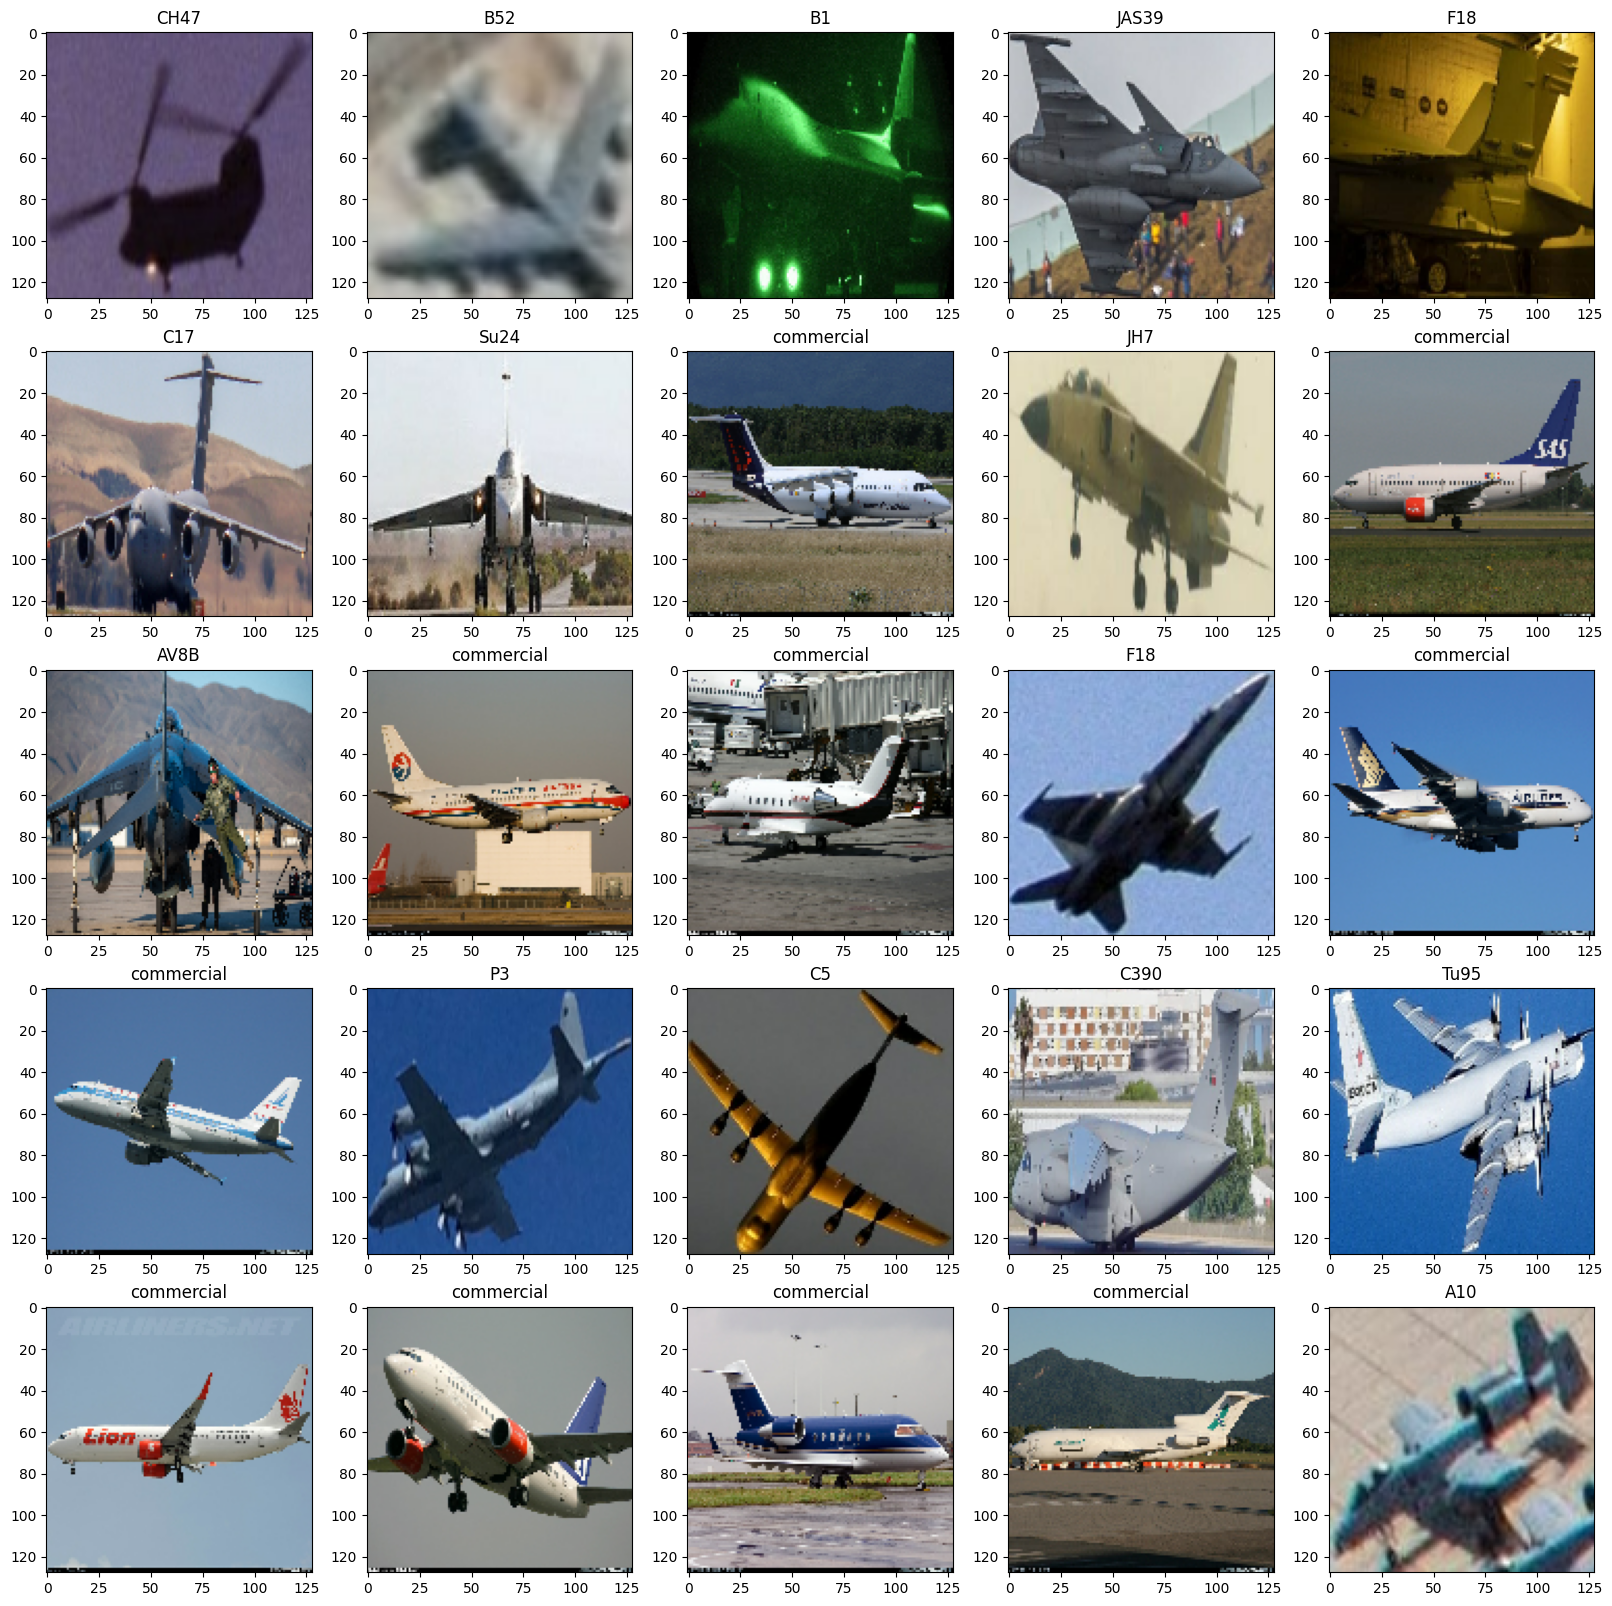

In [ ]:
class_names = train_df.class_names

plt.figure(figsize = (20, 20))
for images, labels in train_df.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

#### <span style='background:#1D2216;color:#ffffff;'> We create prefetch for all datasets </span>

prefetch() function is used to produce a dataset that prefetches the specified elements from this given dataset. It accepts a bufferSize parameter. It is an integer value that specifies the number of elements to be prefetched

In [ ]:
autotune = tf.data.AUTOTUNE
pf_train = train_df.prefetch(buffer_size = autotune)
pf_test = test_df.prefetch(buffer_size = autotune)
pf_val = validation_df.prefetch(buffer_size = autotune)

#### <span style='background:#1D2216;color:#ffffff;'> We create the layers of model here </span>

#### Layer for data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomRotation(0.3))
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))

#### Layers for feature extraction

In [ ]:
# basic setup
image_size = (128, 128)
image_shape = image_size + (3,)

In [ ]:
# input processing
preprocess_input = applications.resnet50.preprocess_input

In [ ]:
# base model (ResNet50)
base_model = applications.ResNet50(input_shape = image_shape, include_top = False, weights = 'imagenet')

In [ ]:
# freeze layers
base_model.trainable = False
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

#### Layers for classification

In [ ]:
nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nclass, activation = 'softmax')

#### <span style='background:#1D2216;color:#ffffff;'> We chain the layers with Functional api </span>

In [ ]:
inputs = tf.keras.Input(shape = image_shape)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128, 128)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128, 128)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128, 128)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 128, 128,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 74)        │    151,626 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,739,338 (90.56 MB)

 Trainable params: 151,626 (592.29 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### <span style='background:#1D2216;color:#ffffff;'> Plotting the model </span>

In [ ]:
image_file = '/kaggle/working/model_plot.png'
plot_model(model, to_file = image_file, show_shapes = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### <span style='background:#1D2216;color:#ffffff;'> Define learning rate schedule, optimizers and compile model </span>

Learning rate schedule is a predefined framework that adjusts the learning rate between epochs or iterations as the training progresses

In [ ]:
optimizer = optimizers.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

#### <span style='background:#1D2216;color:#ffffff;'> Train the model as many as epochs </span>

In [ ]:
history = model.fit(pf_train, validation_data = (pf_val), epochs = 1)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 549s 514ms/step - accuracy: 0.3586 - loss: 3.0317 - val_accuracy: 0.4499 - val_loss: 2.2561


#### <span style='background:#1D2216;color:#ffffff;'> Finetuning the layer of base model </span>

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

#### <span style='background:#1D2216;color:#ffffff;'> Compile again the model </span>

In [ ]:
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

#### <span style='background:#1D2216;color:#ffffff;'> Continue training the model </span>

In [ ]:
ft_epoch = 1
n_epochs =+ ft_epoch

history_fine = model.fit(pf_train, validation_data = (pf_val), epochs = n_epochs, initial_epoch = history.epoch[-1])

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 863s 806ms/step - accuracy: 0.5137 - loss: 1.9995 - val_accuracy: 0.6925 - val_loss: 1.1495


#### <span style='background:#1D2216;color:#ffffff;'> Make predictions using trained model </span>

In [ ]:
model.save('test1.keras')
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


#### <span style='background:#1D2216;color:#ffffff;'> Match labels and predictions </span>

In [ ]:
lab_and_pred = np.transpose(np.vstack((label_batch, pred_labels)))
print(lab_and_pred)

[[26 26]
 [62 62]
 [29 29]
 [30 30]
 [34 34]
 [73 73]
 [23 23]
 [62 62]
 [65 65]
 [27 27]
 [26 26]
 [16 38]
 [27 34]
 [44 44]
 [73 73]
 [13 13]
 [49 49]
 [65 65]
 [27 27]
 [49 49]
 [73 73]
 [47 53]
 [66 66]
 [73 73]
 [73 73]]
